# Customer Churn Prediction + Clustering

Alternative #1bis: 
Features : 6 -> 12 + 3

## 1. Get ready

__Imports__

Import the necessary Spark classes, as well as Python packages for local visualisations.
We will plot the graphs directly in this notebook. If you like to plot them in a separate window, just comment out `%matplotlib inline`.

In [1]:
# Useful imports - PySpark
from pyspark.sql import SparkSession
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

from pyspark.sql import Row

from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import ChiSqSelector
from pyspark.mllib.evaluation import BinaryClassificationMetrics

import numpy as np

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,Current session?
148,None,pyspark,idle,,,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [2]:
%local
%matplotlib inline

# Useful imports for local visualisations

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

__Load the data__

Let's use a table which has been pre-populated in Db2 local. It is called SAMPLES.TRAINING. 

In [3]:
sparkSession = SparkSession \
        .builder \
        .getOrCreate()

df = sparkSession.read \
        .format("com.ibm.idax.spark.idaxsource") \
        .options(dbtable="SAMPLES.TRAINING") \
        .load()
df.show(5)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-----+----+-----+----------+--------+---------+----------+--------+---------+----------+----------+-----------+------------+---------+----------+-----------+---------+
|CHURN|AREA|VMAIL|VMAIL_MSGS|DAY_MINS|DAY_CALLS|DAY_CHARGE|EVE_MINS|EVE_CALLS|EVE_CHARGE|NIGHT_MINS|NIGHT_CALLS|NIGHT_CHARGE|INTL_MINS|INTL_CALLS|INTL_CHARGE|SVC_CALLS|
+-----+----+-----+----------+--------+---------+----------+--------+---------+----------+----------+-----------+------------+---------+----------+-----------+---------+
|    0| 415|    1|         0|   246.5|      108|     41.91|   216.3|       89|     18.39|     179.6|         99|        8.08|     12.7|         3|       3.43|        2|
|    1| 408|    1|         0|   298.1|      112|     50.68|   201.3|      100|     17.11|     214.7|         88|        9.66|      9.7|         4|       2.62|        2|
|    0| 510|    1|         0|   119.3|       82|     20.28|   185.1|      111|     15.73|     157.0|         74|        7.07|     10.9|         4|       2.

How many records do we have? How many features?

In [4]:
print('Number of records: '+str(df.count()))
print('Number of features: '+str(len(df.columns)))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Number of records: 3333
Number of features: 17

## 2. Prepare the data

__Create new columns__

Here we create a new column. Feel free to come up with new feature combinations and transformations.

In [5]:
# TOT_MINS not useful anymore because linear combination of features which are now taken into account.

DAY_MINS_perCALL = df['DAY_MINS']/df['DAY_CALLS']
NIGHT_MINS_perCALL = df['NIGHT_MINS']/df['NIGHT_CALLS']
EVE_MINS_perCALL = df['EVE_MINS']/df['EVE_CALLS']
# type <class 'pyspark.sql.column.Column'>

# to add : price per call, since _CALLS not added to the features
#tot_df = df.withColumn("TOT_MINS", TOT_MINS)
tot_df = df.withColumn("DAY_MINS_perCALL", DAY_MINS_perCALL).withColumn("NIGHT_MINS_perCALL", NIGHT_MINS_perCALL).withColumn("EVE_MINS_perCALL", EVE_MINS_perCALL)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Now we add this new column to the original dataframe and assemble columns into a features outpout column because this is  the format required by PySpark ML functions.

In [6]:
assembler = VectorAssembler(
    inputCols=["SVC_CALLS", "DAY_MINS", "DAY_CHARGE", "VMAIL_MSGS", "VMAIL", 
               "INTL_CALLS", "INTL_CHARGE", "INTL_MINS", "EVE_CHARGE", "EVE_MINS",
               "NIGHT_MINS", "NIGHT_CHARGE", "DAY_MINS_perCALL", "NIGHT_MINS_perCALL", "EVE_MINS_perCALL"],
    outputCol="features")
assembled_df = assembler.transform(tot_df).select("CHURN","features")
assembled_df.printSchema()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- CHURN: short (nullable = false)
 |-- features: vector (nullable = true)

__Split the data__

We split the data into three distinct sets: for training, validation and testing. We use the proportions 70%, 15% and 15% so that we keep a relatively high number of examples for training. Of course these proportions are subjective, you can change them if you want. We have defined a seed so that results can be reproduced.

In [7]:
tot_df.describe().toPandas().transpose()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

                        0                    1  ...               3                4
summary             count                 mean  ...             min              max
CHURN                3333  0.14491449144914492  ...               0                1
AREA                 3333   437.18241824182417  ...             408              510
VMAIL                3333   0.7233723372337234  ...               0                1
VMAIL_MSGS           3333    8.099009900990099  ...               0               51
DAY_MINS             3333            179.77510  ...             0.0            350.8
DAY_CALLS            3333   100.43564356435644  ...               0              165
DAY_CHARGE           3333            30.562307  ...            0.00            59.64
EVE_MINS             3333            200.98035  ...             0.0            363.7
EVE_CALLS            3333   100.11431143114311  ...               0              170
EVE_CHARGE           3333            17.083540  ...            0.

In [8]:
train0, val0, test0 = tot_df.randomSplit([0.70,0.15,0.15],1)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [9]:
train, val, test = train0.dropna(subset = ["DAY_MINS_perCALL", "EVE_MINS_perCALL"]), val0.dropna(subset = ["DAY_MINS_perCALL", "EVE_MINS_perCALL"]), test0.dropna(subset = ["DAY_MINS_perCALL", "EVE_MINS_perCALL"])

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

## 4. Train your algorithm

First, let's see if we can identify some customer clusters with KMeans. We will then apply logistic regression to predict churn.

### a. Apply unsupervised learning for customer segmentation with kMeans

Create a model: Build a Spark ML algorithm that selects the call counts from the customer data and clusters them using KMeans.

In [10]:
# We choose to keep the 12 most relevant features + the newly created ones

assembler_12 = VectorAssembler(
    inputCols=["SVC_CALLS", "DAY_MINS", "DAY_CHARGE", "VMAIL_MSGS", "VMAIL", 
               "INTL_CALLS", "INTL_CHARGE", "INTL_MINS", "EVE_CHARGE", "EVE_MINS",
               "NIGHT_MINS", "NIGHT_CHARGE", "DAY_MINS_perCALL", "NIGHT_MINS_perCALL", "EVE_MINS_perCALL"],
    outputCol="features")

# clusters will be built on training data only
train_12 = assembler_12.transform(train)

# Set characteristics of your model 
kmeans = KMeans().setK(15).setSeed(1)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Fit the model to the required training set and run the algorithm to find the clusters.

In [11]:
model = kmeans.fit(train_12)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [12]:
cluster_predictions = model.transform(train_12)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

__Inference__

KMeans is an unsupervized learning algorithm: we have to see if the clusters we have just built can be really be used to infer churn!

In [13]:
# Number of customers in each cluster
cluster_predictions.groupBy("prediction").count().sort("count").withColumnRenamed("prediction", "ClusterID").show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+---------+-----+
|ClusterID|count|
+---------+-----+
|        3|   92|
|       10|  105|
|        5|  118|
|        8|  120|
|       11|  122|
|        2|  142|
|        1|  144|
|        0|  152|
|       12|  156|
|        9|  156|
|        6|  160|
|       13|  171|
|        4|  179|
|       14|  221|
|        7|  281|
+---------+-----+

__Silhouette score__

The silhouette score measures how similar an object is to its own cluster (cohesion) compared to other clusters (separation). It ranges from −1 to +1. The closer to 1, the better: the object is then well matched to its own cluster and differs from the points belonging to neighboring clusters. If most objects have a high value, then the clustering configuration is considered to be appropriate. Otherwise there may be too many or too few clusters. Here we compute a mean value over all points, using the Euclidean distance.

In [14]:
# Evaluate clustering by computing Silhouette score
evaluator = ClusteringEvaluator()

silhouette = evaluator.evaluate(cluster_predictions)
print("Silhouette with squared euclidean distance = %.3f " % silhouette)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Silhouette with squared euclidean distance = 0.334

* k=15

This allows to target even better our customers: churn propencies go from `4.9% to 57%` (comparison: 6 features : `5.1% to 65%`). We cannot increase the number of clusters too much if we do not have more data, because the model becomes more sensible to outliers.

In [15]:
# Churn proportion in each cluster
churn_proportion = cluster_predictions.groupBy("prediction").avg("CHURN").sort("avg(CHURN)").withColumnRenamed("prediction", "ClusterID")
churn_proportion.show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+---------+-------------------+
|ClusterID|         avg(CHURN)|
+---------+-------------------+
|       11|0.04918032786885246|
|       13|0.05847953216374269|
|        6|             0.0625|
|        7|0.06405693950177936|
|        3|0.08695652173913043|
|       12|0.09615384615384616|
|        9|0.10256410256410256|
|        8|0.11666666666666667|
|        2|0.11971830985915492|
|       10|0.12380952380952381|
|       14|0.12669683257918551|
|        4| 0.1340782122905028|
|        1|             0.1875|
|        0|0.40131578947368424|
|        5| 0.5254237288135594|
+---------+-------------------+

__Cluster mapping__

In [16]:
# Extract ClusterIDs and churn percentages for each cluster
churn_proportion_list = list(churn_proportion.select("avg(CHURN)").toPandas()["avg(CHURN)"])

ClusterID_list = list(churn_proportion.select("ClusterID").toPandas()["ClusterID"])

# Transform into a dictionary:
dico = {}
for i in range(len(ClusterID_list)):
    dico[ClusterID_list[i]] = churn_proportion_list[i]
print(dico)    

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

{11: 0.04918032786885246, 13: 0.05847953216374269, 6: 0.0625, 7: 0.06405693950177936, 3: 0.08695652173913043, 12: 0.09615384615384616, 9: 0.10256410256410256, 8: 0.11666666666666667, 2: 0.11971830985915492, 10: 0.12380952380952381, 14: 0.12669683257918551, 4: 0.1340782122905028, 1: 0.1875, 0: 0.40131578947368424, 5: 0.5254237288135594}

In [17]:
def preparation(DF):
    """
    Inputs : DF is a raw dataframe 
    Outputs : dataframe with additional colmns : features for Clustering, 
    Cluster prediction and corresponding cluster churn percentage
    """

    # We choose to keep only 6 features here (leads to higher cluster separation)
    #assembler_6 = VectorAssembler(inputCols=["TOT_MINS", "VMAIL", "INTL_CALLS", "DAY_CALLS", "SVC_CALLS", "DAY_CHARGE"], outputCol="features")

    # assemble 
    DF_12 = assembler_12.transform(DF)
    
    # Assign each point of the training set to its cluster
    DF_with_clusterIDs = model.transform(DF_12)

    # Create a new dataframe corresponding to the churn percentages for each point
    avgChurn = DF_with_clusterIDs.rdd.map(lambda element : dico[element.prediction])
    row = Row("prediction") 
    avgChurn_df = avgChurn.map(row).toDF().withColumnRenamed("prediction", "ClusterChurn")
    
    # Join tables
    temp1 = avgChurn_df.toPandas()
    temp2 = DF_with_clusterIDs.toPandas()
    temp2["ClusterChurn"] = temp1["ClusterChurn"]
    DF_with_avg = spark.createDataFrame(temp2)
    
    DF_with_avg_renamed = DF_with_avg.withColumnRenamed("features", "featuresClustering").withColumnRenamed("prediction", "predictionClustering")
    print(DF_with_avg_renamed.count())
    
    return DF_with_avg_renamed

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [18]:
prepared_train = preparation(train)
prepared_val = preparation(val)
prepared_test = preparation(test)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

2319
495
516

### b. Apply supervised learning for churn prediction with logistic regression

__Prepare the data__

Select columns and set label names for training. Here we choose to reuse the 6 column selected above. You can test other options if you like.

In [19]:
# Define the assembler
LogReg_assembler = VectorAssembler(
    inputCols=["SVC_CALLS", "DAY_MINS", "DAY_CHARGE", "VMAIL_MSGS", "VMAIL", 
               "INTL_CALLS", "INTL_CHARGE", "INTL_MINS", "EVE_CHARGE", "EVE_MINS",
               "NIGHT_MINS", "NIGHT_CHARGE", 
               "DAY_MINS_perCALL", "NIGHT_MINS_perCALL", "EVE_MINS_perCALL", "ClusterChurn"],
    outputCol="features")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [20]:
# Transform your training set
assembled_train = LogReg_assembler.transform(prepared_train)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [21]:
# Select only the label and features columns
labeled_train = assembled_train.select(assembled_train["features"], assembled_train["CHURN"].alias("label"))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

__Build your model__

In [22]:
# Define your model
logReg = LogisticRegression(maxIter=100)

# Fit the model
logRegModel = logReg.fit(labeled_train)

# Make predictions
pred_train = logRegModel.transform(labeled_train)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

__Area under Curve__

In [23]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
binEval_AUROC = BinaryClassificationEvaluator().setMetricName("areaUnderROC").setRawPredictionCol("rawPrediction").setLabelCol("label")
print("Area under ROC: %.3f" % binEval_AUROC.evaluate(pred_train))

binEval_AUPRC = BinaryClassificationEvaluator().setMetricName("areaUnderPR").setRawPredictionCol("rawPrediction").setLabelCol("label")
print("Area under PR curve: %.3f" % binEval_AUPRC.evaluate(pred_train))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Area under ROC: 0.799
Area under PR curve: 0.467

ROC increased by 2%
Area under PR curve increased by 1%

__PRC__ error?

Compute raw scores on the test set

#predictionAndLabels = pred_train.rdd.map(lambda lp: (lp.rawPrediction, lp.label))
#TypeError: field score: DoubleType can not accept object DenseVector([3.306, -3.306]) in type <class 'pyspark.ml.linalg.DenseVector'>

#predictionAndLabels = labeled_train.rdd.map(lambda lp: (float(logRegModel.predict(lp.features)), lp.label))
#Could not serialize object: Py4JError: An error occurred while calling o746.__getstate__. Trace:
#py4j.Py4JException: Method __getstate__([]) does not exist

predictionAndLabels = pred_train.rdd.map(lambda el : (el.rawPrediction, el.label))

Instantiate metrics object

metrics = BinaryClassificationMetrics(predictionAndLabels)

Area under precision-recall curve

print("Area under PR = %s" % metrics.areaUnderPR)

Area under ROC curve

print("Area under ROC = %s" % metrics.areaUnderROC)

__Visualize feature importance__

In [24]:
# Print the coefficients and intercept for logistic regression
print("Coefficients: " + str(logRegModel.coefficients))
print("Intercept: " + str(logRegModel.intercept))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Coefficients: [0.47070088854633846,0.0029603161095587177,0.01762941305452056,0.03305096931248304,1.8487859268027127,-0.10114988548033757,0.19823271019233485,0.043511535809216455,0.02604425064231895,0.002338407402565874,0.0009246150875325816,0.021618889311868884,-0.11166198357915838,-0.08206326565526705,-0.13464707674918505,5.117348227991164]
Intercept: -7.532085641829511

16
16


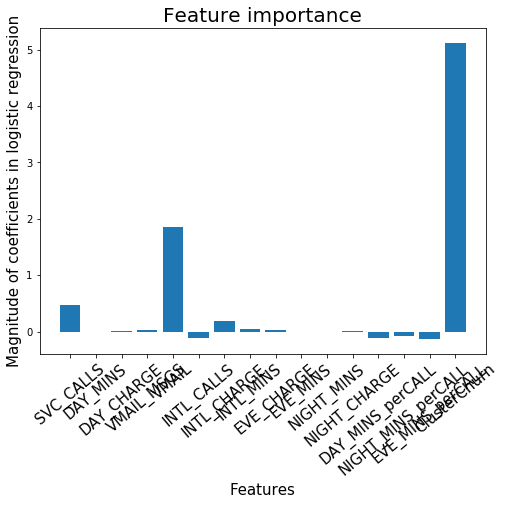

In [26]:
%local

features=["SVC_CALLS", "DAY_MINS", "DAY_CHARGE", "VMAIL_MSGS", "VMAIL", 
               "INTL_CALLS", "INTL_CHARGE", "INTL_MINS", "EVE_CHARGE", "EVE_MINS",
               "NIGHT_MINS", "NIGHT_CHARGE", 
               "DAY_MINS_perCALL", "NIGHT_MINS_perCALL", "EVE_MINS_perCALL", "ClusterChurn"]
print(len(features))
coeffs= [0.47070088854633846,0.0029603161095587177,0.01762941305452056,0.03305096931248304,1.8487859268027127,-0.10114988548033757,0.19823271019233485,0.043511535809216455,0.02604425064231895,0.002338407402565874,0.0009246150875325816,0.021618889311868884,-0.11166198357915838,-0.08206326565526705,-0.13464707674918505,5.117348227991164]
print(len(coeffs))
#note : adapt coeffs and features list if you modified the features

ax, fig=plt.subplots(figsize=(8,6))
index = np.arange(len(features))
plt.bar(index, coeffs)

plt.xlabel('Features', fontsize=15)
plt.ylabel('Magnitude of coefficients in logistic regression', fontsize=15)
plt.xticks(index, features, fontsize=15, rotation=40)
plt.title('Feature importance', fontsize=20)

plt.show()

Features which have the higher weight in the predictive model are unchanged compared to the 6-feature case :

* ClusterChurn
* VMAIL
* SVC_CALLS

The model is almost exclusively based on three features!

Before the introduction of the ClusterChurn column it was overwhelmingly based on VMAIL, SVC_CALLS and INTL_CALLS.

__Metrics and confusion matrix__


Let's have a look at some indicators.

* Confusion matrix 

<img src="confusionMatrix.png" width=800/>

Sensitivity = TP / (TP + FN), also called Recall

Specificity = TN / (TN + FP)

Precision = TP / (TP + FP)

Negative Predictive Value = TN / (TN + FN)

F1-score: 2 x Precision x Recall / (Precision + Recall)

Recall = 1 - FNR. 

In [27]:
# Metrics (1/2)

evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(pred_train)
print("Accuracy = %.3f" % accuracy)

evaluatorf1 = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")
f1 = evaluatorf1.evaluate(pred_train)
print("f1 = %.3f" % f1)
 
evaluatorwp = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedPrecision")
wp = evaluatorwp.evaluate(pred_train)
print("weightedPrecision = %.3f" % wp)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Accuracy = 0.871
f1 = 0.844
weightedPrecision = 0.848

Almost no improvement

Note : weighted precision and recall means that values were weighted by the number of elements in each class. Weighted recall is equal to accuracy. Without weights: see below.

In [28]:
# Metrics (2/2)

def confusion_matrix(pred_DF):
    """
    Input : 
    pred_DF : Saprk DataFrame obtained after a model.transform() transformation
    Output :
    (tn, fp, fn, tp) tuple of integers
    """
    
    # as pandas DF
    label = pred_DF.toPandas()["label"]
    prediction = pred_DF.toPandas()["prediction"]
    
    # true = tp + tn
    true = sum(label)

    # tp : sum(if pred = label = 1) or count(pred+label=2)
    tp = sum(label+prediction==2)
    
    # fn = total number of positive - predicted positives which are rightly predicted
    fn = true - tp

    # tn : sum(if pred=label=0) or count(pred+label=0)
    tn = sum(label+prediction==0)

    # fp = total number of negative - tn
    fp = len(label) - true - tn
    
    return (tn, fp, fn, tp)


def FNR(fn, tp):
    return fn/(fn+tp)

def recall(tp, fn):
    # also called TPR or sensitivity
    return tp/(tp+fn)

def precision(tp, fp):
    return tp/(tp+fp)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [29]:
# Confusion matrix
(tn, fp, fn, tp)=confusion_matrix(pred_train)
# Confusion matrix in format [[tp, fn], [fp, tn]]
print("Confusion matrix: ")
print(np.array([[("tp: "+str(tp)), ("fn: "+str(fn))], [("fp: "+str(fp)), ("tn: "+str(tn))]]))

# Metrics
print("FNR: %.3f" % FNR(fn, tp))
print("Recall: %.3f" % recall(tp, fn))
print("Precision: %.3f" % precision(tp, fp))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Confusion matrix: 
[['tp: 74' 'fn: 255']
 ['fp: 43' 'tn: 1947']]
FNR: 0.775
Recall: 0.225
Precision: 0.632

Recall improved! by 8%

## 5. Fine tune your hyperparameters on the validation set

We will only do it for logistic regression, since it is the more promising model so far. A similar method can be applied for the other model types.

__Raw results__

In the following cell, default values are used for logistic regression's parameters. 

In [30]:
# Transform your validation set
assembled_val = LogReg_assembler.transform(prepared_val)

# Select only the label and features columns
labeled_val = assembled_val.select(assembled_val["features"], assembled_val["CHURN"].alias("label"))

# Make predictions
pred_val = logRegModel.transform(labeled_val)

# Define evaluator
evaluator = MulticlassClassificationEvaluator(metricName="accuracy")

# Compute the classification accuracy on the validation set
accuracy = evaluator.evaluate(pred_val)
print("Validation Accuracy = %.3f" %  accuracy)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Validation Accuracy = 0.851

Accuracy had improved by 2%: 0.855 compared to 0.834 without the additional ClusterChurn column.
drops again in 12-feature case.

__Grid search__ 

In the next cell we define a function to test a range of hyperparameters for regularization in order to minimize the False Negative Rate (FNR).

In [31]:
def grid_search():
    """
    Input:
    DF : Spark Dataframe, prepared with features and label columns
    
    Output:
    best: dictionary with best hyperparameters and corresponding metrics
    """
       
    # Hyperparameter ranges
    regParam_range=[0, 0.001, 0.002, 0.005, 0.01]
    elasticNetParam_range=[0, 0.001, 0.002, 0.005, 0.01]
    
    best={"regParam":0, "elasticNetParam": 0, "training_FNR": 1, "validation_FNR": 1}
          
    for r in regParam_range:
        for e in elasticNetParam_range:
            
            print("regParam = "+str(r)+" , elasticNetParam = "+ str(e))
            
            # Define your model
            logReg = LogisticRegression(maxIter=100, regParam=r, elasticNetParam=e)

            # Fit the model on training set
            logRegModel = logReg.fit(labeled_train)

            # Make predictions
            pred_train = logRegModel.transform(labeled_train)
            pred_val = logRegModel.transform(labeled_val)
            
            # Compute the confusion matrix and FNR for both sets
            (tn, fp, fn, tp) = confusion_matrix(pred_train)
            training_FNR = FNR(fn, tp)
            (tn, fp, fn, tp) = confusion_matrix(pred_val)
            val_FNR = FNR(fn, tp)
            print("Training FNR = " +str(training_FNR))
            print("Validation FNR = " +str(val_FNR))
            print("")
            
            if val_FNR <= best["validation_FNR"]: # to have more regularization for equal performance
                best["regParam"] = r
                best["elasticNetParam"] = e
                best["training_FNR"] = training_FNR
                best["validation_FNR"] = val_FNR
                
    return best

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [32]:
best = grid_search()
print(best)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

regParam = 0 , elasticNetParam = 0
Training FNR = 0.7750759878419453
Validation FNR = 0.7682926829268293

regParam = 0 , elasticNetParam = 0.001
Training FNR = 0.7750759878419453
Validation FNR = 0.7682926829268293

regParam = 0 , elasticNetParam = 0.002
Training FNR = 0.7750759878419453
Validation FNR = 0.7682926829268293

regParam = 0 , elasticNetParam = 0.005
Training FNR = 0.7750759878419453
Validation FNR = 0.7682926829268293

regParam = 0 , elasticNetParam = 0.01
Training FNR = 0.7750759878419453
Validation FNR = 0.7682926829268293

regParam = 0.001 , elasticNetParam = 0
Training FNR = 0.7750759878419453
Validation FNR = 0.7682926829268293

regParam = 0.001 , elasticNetParam = 0.001
Training FNR = 0.7750759878419453
Validation FNR = 0.7804878048780488

regParam = 0.001 , elasticNetParam = 0.002
Training FNR = 0.7781155015197568
Validation FNR = 0.7804878048780488

regParam = 0.001 , elasticNetParam = 0.005
Training FNR = 0.7750759878419453
Validation FNR = 0.7804878048780488

reg

## 6. Assess your model performance on the test set

See what is the final perfomance of your tuned model on unseen data.

In [33]:
# Prepare the test set
assembled_test = LogReg_assembler.transform(prepared_test)

# Select only the label and features columns
labeled_test = assembled_test.select(assembled_test["features"], assembled_test["CHURN"].alias("label"))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [34]:
# Define your model
logReg = LogisticRegression(maxIter=100, regParam=best["regParam"], elasticNetParam=best["elasticNetParam"])

# Fit the model on training set
logRegModel = logReg.fit(labeled_train)

# Make predictions on test set
pred_test = logRegModel.transform(labeled_test)
pred_test.show(5)

# Compute the accuracy on the test set
print("Test Accuracy = %.3f" %evaluator.evaluate(pred_test))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+-----+--------------------+--------------------+----------+
|            features|label|       rawPrediction|         probability|prediction|
+--------------------+-----+--------------------+--------------------+----------+
|[1.0,199.1,33.85,...|    0|[2.66436793539785...|[0.93489104741464...|       0.0|
|[0.0,204.9,34.83,...|    0|[3.22016714033588...|[0.96158618883629...|       0.0|
|[1.0,291.1,49.49,...|    0|[0.04634360072981...|[0.51158382701291...|       0.0|
|[1.0,141.8,24.11,...|    0|[3.12445227678408...|[0.95789018434366...|       0.0|
|[0.0,306.2,52.05,...|    0|[1.99112818646314...|[0.87986244306212...|       0.0|
+--------------------+-----+--------------------+--------------------+----------+
only showing top 5 rows

Test Accuracy = 0.872

In [35]:
# Confusion matrix
(tn, fp, fn, tp)=confusion_matrix(pred_test)
# Confusion matrix in format [[tp, fn], [fp, tn]]
print("Confusion matrix: ")
print(np.array([[("tp: "+str(tp)), ("fn: "+str(fn))], [("fp: "+str(fp)), ("tn: "+str(tn))]]))

# FNR
print("FNR: %.3f" %FNR(fn, tp))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Confusion matrix: 
[['tp: 16' 'fn: 55']
 ['fp: 11' 'tn: 434']]
FNR: 0.775

Comparison : 
* (22, 50, 12, 433) FNR: 0.694 - 12 features + ClusterChurn
* (18, 54, 4, 441) FNR = 0.750 - 6 features + ClusterChurn
* (12, 60, 4, 441), FNR = 0.833 without ClusterChurn column 

__Plot the ROC curve__ 

The Receiver-Operator Curve (ROC) gives you a visual display of the sensitivity by specificity for all possible classification cutoffs. In other words, it summarizes the trade-off between the true positive rate and false positive rate for a predictive model using different probability thresholds.

The true positive rate (TPR) is given by `tp / (tp + tn)` where tp is the number of true positives and tn the number of true negatives. It is also referred to as recall or sensitivity.

The false positive rate (FPR) is given by `fp/(fp+tn)` where fp is the number of false positives and tn the number of true negatives. It is also referred to as inverted specificity.

In [36]:
# Extract the summary from the returned LogisticRegressionModel instance trained
trainingSummary = logRegModel.summary
# Obtain the receiver-operating characteristic as a dataframe and areaUnderROC.
trainingSummary.roc.createOrReplaceTempView("roc")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [37]:
%%sql -o roc --maxrows -1
SELECT * FROM roc

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

/Users/eva.feillet/anaconda3/lib/python3.7/site-packages/autovizwidget/widget/utils.py:50: FutureWarning:

A future version of pandas will default to `skipna=True`. To silence this warning, pass `skipna=True|False` explicitly.



Output()

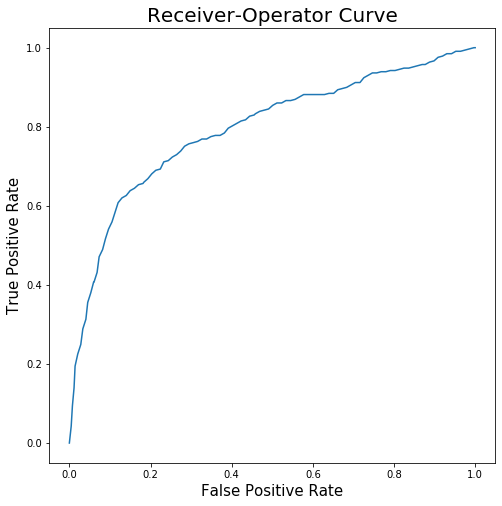

In [38]:
%local
ax, fig = plt.subplots(figsize=(8,8))
plt.xlabel("False Positive Rate", fontsize=15)
plt.ylabel("True Positive Rate", fontsize=15)
plt.title("Receiver-Operator Curve", fontsize=20)
plt.plot(roc["FPR"], roc["TPR"])

In [39]:
print("areaUnderROC: %.3f" %trainingSummary.areaUnderROC)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

areaUnderROC: 0.793

__Gains chart__

In [ ]:
pred_test.show(5)

In [ ]:
# Order by growing churn probability

# Extract proba1
pred_test1 = pred_test.rdd.map(lambda element : [element.probability[1], element.label, element.prediction])
pred_test1.take(2)

# Order by proba1
ordered_pred_test1 = pred_test1.sortBy(lambda x: x[0])
ordered_pred_test1.take(10)

# Convert back to dataframe
#ordered_DF = ordered_pred_test1.toDF()
# .map(Row("colName")).toDF()
#issue : no schema for PipelinedRDD

# Create temporary view
# ordered_DF.createOrReplaceTempView("ordered_DF")

In [ ]:
pred_test.createOrReplaceTempView("pred_test")

In [ ]:
%%sql -o pred_test --maxrows -1
SELECT * FROM pred_test

In [ ]:
%local

# Extract the relevant data

# Predicted proba that label is 1
proba1 = [x["values"][1] for x in pred_test["probability"]]
# equivalent to 
# proba1 = pred_test.select("probability").toPandas().values.tolist()

pred_test["proba1"] = pd.Series(proba1)
sorted_pred_test = pred_test.sort_values(by="proba1").drop(["features", "rawPrediction", "probability"], axis=1)

In [ ]:
%local
sorted_pred_test

In [ ]:
%local

# Reset index
sorted_pred_test = sorted_pred_test.reset_index(drop=True)
n = len(sorted_pred_test)

# Add cumulated count for #customers and cumulated frequency for %churners

#Initialize columns
sorted_pred_test["#Customers"] = pd.Series([0 for x in range(n)])
sorted_pred_test["#predChurners"] = pd.Series([0 for x in range(n)])
sorted_pred_test["#trueChurners"] = pd.Series([0 for x in range(n)])

# case i = 0
sorted_pred_test["#Customers"][0] = 1
sorted_pred_test["#predChurners"][0] = sorted_pred_test["prediction"][0]
sorted_pred_test["#trueChurners"][0] = sorted_pred_test["label"][0]

# case i>0
for i in range(1,n):
    sorted_pred_test["#Customers"][i] = i+1
    sorted_pred_test["#predChurners"][i] = sorted_pred_test["#predChurners"][i-1] + sorted_pred_test["prediction"][i]
    sorted_pred_test["#trueChurners"][i] = sorted_pred_test["#trueChurners"][i-1] + sorted_pred_test["label"][i]

sorted_pred_test["#predChurners"]/=n   
sorted_pred_test["#trueChurners"]/=n 

sorted_pred_test

In [ ]:
%local

ax, fig=plt.subplots(figsize=(8,6))

x = sorted_pred_test["#Customers"].values.tolist()
y = [sorted_pred_test["#trueChurners"].values.tolist(), sorted_pred_test["#predChurners"].values.tolist()]
labels = ["true churners", "predicted churners"]

for y_arr, label in zip(y, labels):
    plt.plot(x, y_arr, label=label)

plt.xlabel('Customer Count', fontsize=15)
plt.ylabel('True and predicted churners in %', fontsize=15)
ax.legend(loc='center')
plt.title('Cumulative Gains Curves', fontsize=20)

plt.show()    

## What you've learned

Congratulations!

Through this notebook, you've learned how to:
* use PySpark for a classic workflow, from data preparation to model assessment
* perform feature engineering by combining different ML techniques
* build models using both supervised and unsupervised learning
* compute and visualize useful indicators in order to evaluate a model.

___
## Authors

Eva Feillet - ML intern, IBM Cloud and Cognitive Software, IBM Lab in Böbligen, Germany

__Licence__

to add